In [1]:
%matplotlib widget
# Add the directory containing the package to sys.path
import sys, os
package_dir = os.path.abspath("C:/Users/froll/Documents/Labo/Projets/Outils/swd")
if package_dir not in sys.path:
    sys.path.insert(0, package_dir)
    
from swd import spherical_processing as sp
from swd import geotools as geo
from swd import plots as splots
import swd as swd
import importlib

importlib.reload(swd.plots)
import numpy as np
from numpy import pi, cos, sin
import matplotlib.pyplot as plt

import warnings
#from utils_DirViolins import *
warnings.filterwarnings("ignore")
from tqdm import tqdm
np.set_printoptions(precision=2, suppress=True)
# Enable LaTeX rendering
plt.rc('text', usetex=True)

In [2]:
#Vitesse du son au moment de la mesure, dependant de la temperature:
Tc = 21.5 
C = np.sqrt( 1.4 * 287 *(Tc + 273) )
Path = './'
NbMems = 256
NbViolTot = 6
NbViol = 6
OSH = 7

NbSH = (OSH+1)**2
NumViolon = np.load('NumViolon.npz')['NumViolon']
XYZViolins = np.load('../results/XYZViolinsAligned.npy')

NbMics = 256
NbSrcs = XYZViolins.shape[0] - NbMics

XYZHammerImpact = XYZViolins[NbSrcs-1]
XYZ = XYZViolins-XYZHammerImpact
XYZs = XYZ[:NbSrcs-1]
XYZm = XYZ[NbSrcs:]
XYZHammerImpact = XYZ[NbSrcs-1]


In [3]:
# Violin positioning
# Define rotation functions locally to avoid dependency issues
def x_rotate_coordinates(coords, a):
    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(a), -np.sin(a)],
        [0, np.sin(a), np.cos(a)]
    ])
    return np.dot(R_x, coords)

def y_rotate_coordinates(coords, a):
    R_y = np.array([
        [np.cos(a), 0, np.sin(a)],
        [0, 1, 0],
        [-np.sin(a), 0, np.cos(a)]
    ])
    return np.dot(R_y, coords)

def z_rotate_coordinates(coords, a):
    R_z = np.array([
        [np.cos(a), -np.sin(a), 0],
        [np.sin(a), np.cos(a), 0],
        [0, 0, 1]
    ])
    return np.dot(R_z, coords)

import trimesh
#Dimensions hors tout du violon Stradivarius Willemotte 1732, d'apres les mesures de Sacconi:
Wv = 206.5e-3  # Convert mm to meters
Lv = 485.7e-3
Hv = 94.7e-3

mesh = trimesh.load('../src/Meshes/violin.ply')  # Can also load .obj or .mtl files
# Extract vertices and faces
vertices = mesh.vertices
vertices -= vertices.mean(axis=0)
rx = 90 * pi/180 
ry = 0 * pi/180 
rz = -90 * pi/180
vertices = x_rotate_coordinates(vertices.T,    rx).T
vertices = y_rotate_coordinates(vertices.T,    ry).T
vertices = z_rotate_coordinates(vertices.T,    rz).T

Dims0 = vertices.max(axis=0) - vertices.min(axis=0)
DimsV = np.array([Hv, Wv, Lv])

Scale = DimsV / Dims0
print(Dims0, DimsV, Scale)
vertices *= Scale

SommetChevalet = vertices[np.abs(vertices[:,0]).argmax()]
print(SommetChevalet)

vertices -= SommetChevalet

print(SommetChevalet)

faces = mesh.faces



[1.24 2.26 6.66] [0.09 0.21 0.49] [0.08 0.09 0.07]
[-0.05 -0.   -0.14]
[0. 0. 0.]


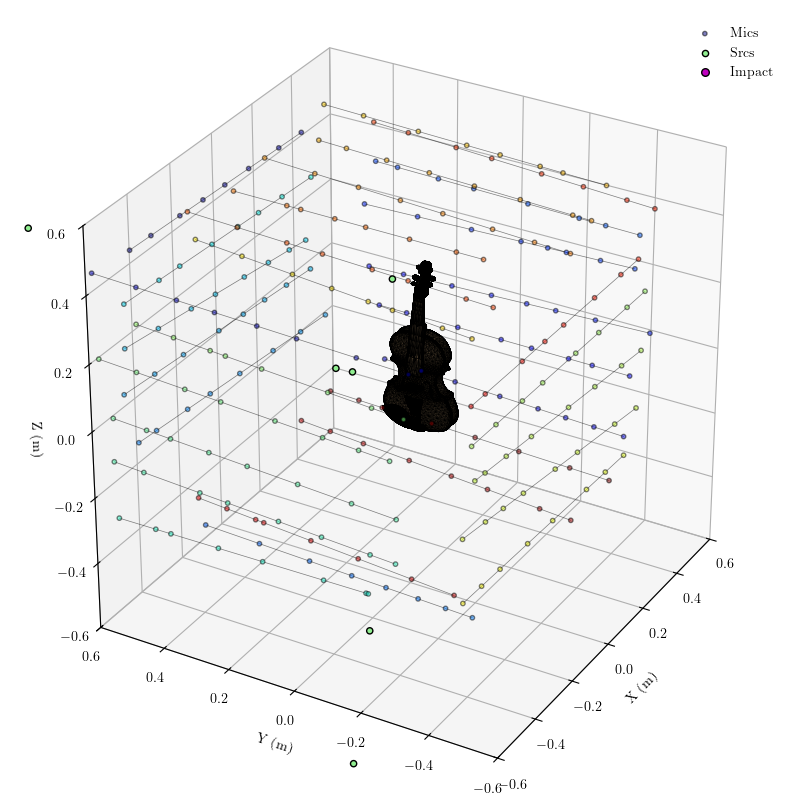

In [4]:
fig = plt.figure(1, figsize=(8, 8))
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(*XYZm.T, c =np.arange(NbMics), marker='o',edgecolor='k', s=10, cmap='jet',alpha = 0.5, label = 'Mics')
ax2.scatter(*XYZs.T, marker='o',facecolor ='lightgreen',edgecolor='k', s=20, alpha=1, label = 'Srcs')
ax2.scatter(*XYZHammerImpact.T, marker = 'o', facecolor ='m', edgecolor='k', s=30 ,label='Impact')

for i in range(0, NbMics, 8):
    ax2.plot(XYZm[i:i+8,0], XYZm[i:i+8,1], XYZm[i:i+8,2], color='k', linewidth=0.5, alpha=0.5)

#ax2.set_label([str(i) for i in NumF])
ax2.legend()  
L = 0.6
ax2.set_xlim([-L,L])
ax2.set_ylim([-L,L])
ax2.set_zlim([-L,L])
ax2.set_aspect('equal')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

light_brown = (0.87, 0.72, 0.53)  # RGB values for light brown
mesh_collection = Poly3DCollection(vertices[faces], alpha=0.75, edgecolor='k', facecolor=light_brown)
ax2.add_collection3d(mesh_collection)
# Set labels
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)')

ax2.view_init(elev=30, azim=210, roll=0) 
ax2.dist = 0.1  
ax2.legend(loc='upper right', fontsize=10, frameon=False)
plt.tight_layout()
# Show the plot
plt.show()

In [5]:

# 3D Visualization using pythreejs
try:
    from pythreejs import *
    from IPython.display import display
except ImportError:
    print("pythreejs is not installed. Please install it using: %pip install pythreejs")

if 'pythreejs' in sys.modules:
    # Helper to create BufferAttribute
    def make_buffer_attr(array):
        return BufferAttribute(array=array.astype(np.float32, copy=False))

    scene_children = []

    # Microphones (Mics) - Blue Spheres
    mics_geo = SphereGeometry(radius=0.0075, widthSegments=8, heightSegments=8)
    mics_mat = MeshLambertMaterial(color='blue')
    for pos in XYZm:
        scene_children.append(Mesh(geometry=mics_geo, material=mics_mat, position=pos.tolist()))

    # Sources (Srcs) - Green Spheres
    srcs_geo = SphereGeometry(radius=0.01, widthSegments=8, heightSegments=8)
    srcs_mat = MeshLambertMaterial(color='lightgreen')
    for pos in XYZs:
        scene_children.append(Mesh(geometry=srcs_geo, material=srcs_mat, position=pos.tolist()))

    # Impact - Magenta Sphere
    impact_geo = SphereGeometry(radius=0.015, widthSegments=16, heightSegments=16)
    impact_mat = MeshLambertMaterial(color='magenta')
    scene_children.append(Mesh(geometry=impact_geo, material=impact_mat, position=XYZHammerImpact.tolist()))

    # Lines connecting mics in chunks of 8
    line_positions = []
    for i in range(0, NbMics, 8):
        # Create segments (0,1), (1,2), ..., (6,7)
        for j in range(7):
            if i + j + 1 < NbMics:
                line_positions.append(XYZm[i+j])
                line_positions.append(XYZm[i+j+1])
    
    line_positions = np.array(line_positions)
    if len(line_positions) > 0:
        lines_geo = BufferGeometry(attributes={'position': make_buffer_attr(line_positions)})
        lines_mat = LineBasicMaterial(color='black', linewidth=1, transparent=True, opacity=0.5)
        lines = LineSegments(geometry=lines_geo, material=lines_mat)
        scene_children.append(lines)

    # Violin Mesh
    if 'vertices' in locals() and 'faces' in locals():
        # Faces must be flattened for index
        faces_flat = faces.flatten().astype(np.uint32)
        
        mesh_geo = BufferGeometry(
            attributes={
                'position': make_buffer_attr(vertices),
                'index': BufferAttribute(array=faces_flat, itemSize=1)
            }
        )
        
        # Simple light brown material
        # Note: For proper lighting, normals are needed. 
        # We can try to rely on pythreejs/threejs computing them or use basic material if it looks bad.
        # MeshLambertMaterial requires normals. MeshBasicMaterial does not but has no shading.
        # Let's try to add normals if we can, or use double side.
        
        # Adding a helper to compute normals (requires knowing structure, usually handled by three.js helper but pythreejs is low level)
        # We'll use MeshLambert and hope for the best, or create normals via trimesh if possible.
        # vertices are already modified, normals need to be recomputed.
        
        # Re-computing normals using trimesh relative to the transformed vertices
        # We can create a temporary trimesh object to compute vertex normals
        try:
            tm_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
            tm_mesh.fix_normals()
            normals = tm_mesh.vertex_normals
            mesh_geo.attributes['normal'] = make_buffer_attr(normals)
        except:
             pass 

        mesh_mat = MeshLambertMaterial(color='#DEB887', transparent=True, opacity=0.75, side='DoubleSide')
        violin_mesh = Mesh(geometry=mesh_geo, material=mesh_mat)
        scene_children.append(violin_mesh)

        # Add mesh edges (wireframe)
        wireframe_geo = WireframeGeometry(geometry=mesh_geo)
        wireframe_mat = LineBasicMaterial(color='black', linewidth=1, transparent=True, opacity=0.2)
        wireframe = LineSegments(geometry=wireframe_geo, material=wireframe_mat)
        scene_children.append(wireframe)

    # Scene
    scene = Scene(children=scene_children)

    # Lights
    key_light = DirectionalLight(color='white', position=[5, 5, 10], intensity=0.8)
    fill_light = DirectionalLight(color='white', position=[-5, 0, 5], intensity=0.5)
    amb_light = AmbientLight(color='#777777')
    scene.add([key_light, fill_light, amb_light])

    # Camera
    camera = PerspectiveCamera(position=[0.5, -0.5, 0.5], up=[0, 0, 1], aspect=1.0, fov=50)
    camera.lookAt([0, 0, 0])

    # Controls
    controls = OrbitControls(controlling=camera)
    
    # Renderer with square aspect ratio (800x800)
    renderer = Renderer(camera=camera, scene=scene, controls=[controls], width=800, height=800)
    display(renderer)

Renderer(camera=PerspectiveCamera(position=(0.5, -0.5, 0.5), projectionMatrix=(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0…

In [6]:
Pm = np.load('ViolinsPm.npz')['Pm']
frq = np.load('ViolinsPm.npz')['frq']

NbTh = 52   #Nombre de theta                                    
NbPh = 52   #Nombre de phi
frqMax = 10000
CyclicScale = 'icefire' #edge, icefire, phase, hsv
RealScale = 'seismic'
Magnitudescale = 'inferno'

## Process the Spherical Harmonics Spectra for each Violin

In [7]:
Rm = np.linalg.norm(XYZm,axis=1)
Rmin = np.min(Rm)

In [8]:

Band = (frq>0) & (frq<frqMax)
f = frq[Band]
Nbf = len(f)
kvect= 2*pi*f.T/C
Nang = 50
NbTh, NbPh = 2*Nang+2, 2*Nang+2
angles_look, weights = swd.geotools.create_equal_angle_grid(Nang)

In [9]:
ProcessCmn = False
O_SH_vect = sp.compute_N_SH_vect(f,N_SH_max = OSH,rmin = Rmin)
Ho2f = sp.compute_SphericalWavesbasis_origin_to_field(XYZm, kvect, OSH, SH_center = np.array([0,0,0], dtype = float))
NbDirs = angles_look.shape[0]

if ProcessCmn:
    Cmn = np.zeros((NbViol, NbSH, Nbf), dtype = np.complex128)    
    Diag = np.zeros((NbViol, NbDirs, Nbf), dtype = np.complex128)
    for v in tqdm(range(NbViol)):
        P  = Pm[v,Band,:].T
        Cmn[v,:,:] = sp.compute_SHcoefs(P,Ho2f,O_SH_vect, lambda_reg=1e-4)
        Diag[v,:,:] = sp.compute_Dinf_from_SH_coefs_at_origin(Cmn[v,:,:], angles_look, kvect)

    np.savez(f'Cmn.npz', Cmn = Cmn)
    np.savez(f'Diag.npz', Diag = Diag, angles_look = angles_look)
else:
    Cmn = np.load(f'Cmn.npz')['Cmn']
    Diag = np.load(f'Diag.npz')['Diag']

In [10]:
OSHSpec = []
no = 0
for o in range(OSH+1):
    sho = np.arange(2*o+1) + no
    no = sho[-1]+1
    OSHSpec.append(np.abs(np.sum(Cmn[:,sho,:], axis = 1))**2)
OSHSpec = np.rollaxis(np.array(OSHSpec),1,0)
OSHSpecN = OSHSpec/np.max(OSHSpec, axis = (1,2))[:,None,None]
OSHSpecdB = 10*np.log10(OSHSpec/np.max(OSHSpec))
OSHSpecdBmax = np.max(OSHSpecdB)

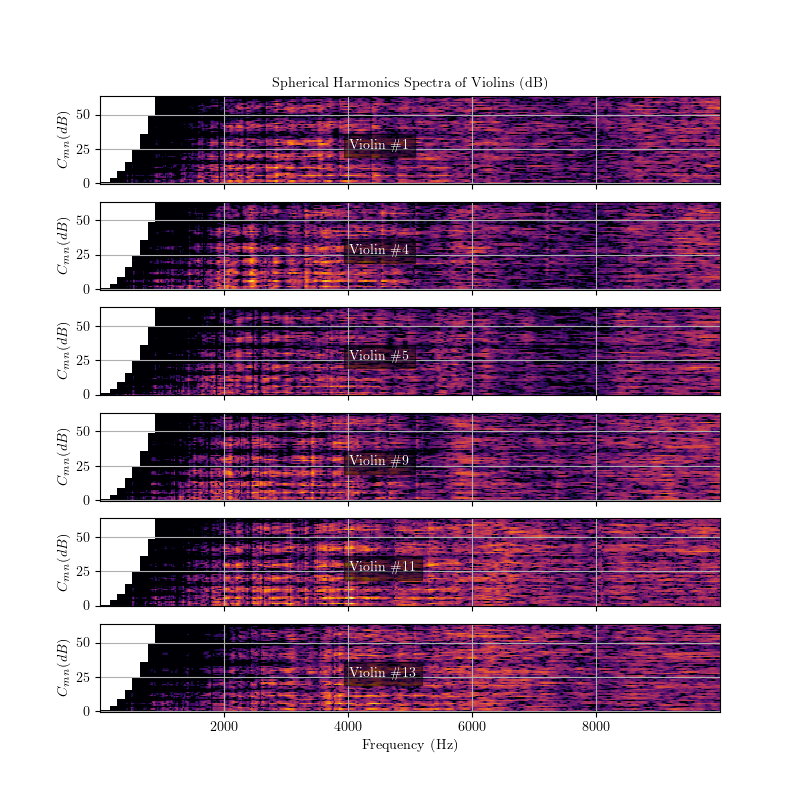

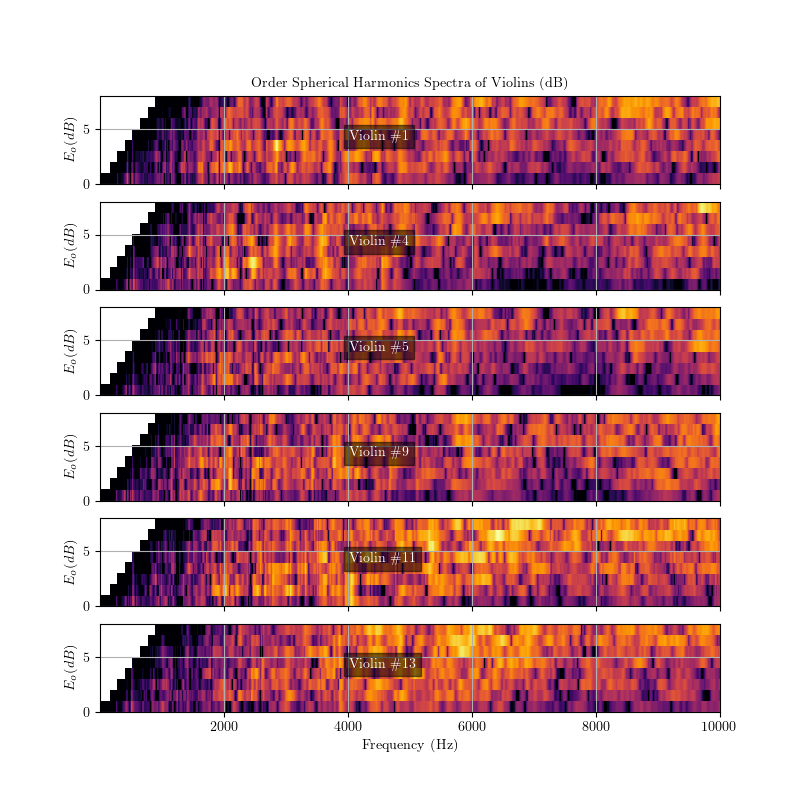

In [11]:
CmndB = 20*np.log10(np.abs(Cmn)/np.max(np.abs(Cmn)))
CmndBmax = np.max(CmndB)
Dyn = 36

NumViolon = [1, 4, 5, 9, 11, 13]  # Violons a analyser

figH,axH = plt.subplots(NbViol,1,figsize=(8,8))
figO,axO = plt.subplots(NbViol,1,figsize=(8,8))
for v in range(NbViol):
    c = axH[v].pcolor(f, np.arange(NbSH), CmndB[v,:,:], cmap=Magnitudescale, shading='nearest', vmin=CmndBmax-Dyn, vmax=CmndBmax)    
    axH[v].set_ylabel('$C_{mn} (dB)$')
    axH[v].grid()    
    axH[v].annotate(f"Violin \#{NumViolon[v]:d}", xy=(3800, 25), xytext=(10, 0), textcoords='offset points', color='white',
            bbox=dict(facecolor='black', alpha=0.5))
    if v < NbViol-1:
        axH[v].set_xticklabels([])
    else:    
        axH[v].set_xlabel('Frequency (Hz)')     
    if not v : 
        axH[v].set_title('Spherical Harmonics Spectra of Violins (dB)')   
        #fig.colorbar(c, ax[v]) 
    X = np.arange(f[0],f[-1]+2*(f[1]-f[0]),f[1]-f[0])
    c = axO[v].pcolor(X, np.arange(OSH+2), OSHSpecdB[v,:,:], cmap=Magnitudescale, shading='flat', vmin=OSHSpecdBmax-Dyn, vmax=OSHSpecdBmax)    
    axO[v].set_ylabel('$E_o (dB)$')
    axO[v].grid()    
    axO[v].annotate(f"Violin \#{NumViolon[v]:d}", xy=(3800, 4), xytext=(10, 0), textcoords='offset points', color='white',
            bbox=dict(facecolor='black', alpha=0.5))
    if v < NbViol-1:
        axO[v].set_xticklabels([])
    else:    
        axO[v].set_xlabel('Frequency (Hz)')     
    if not v : 
        axO[v].set_title('Order Spherical Harmonics Spectra of Violins (dB)')   
        #fig.colorbar(c, ax[v]) 
#fig.tight_layout()

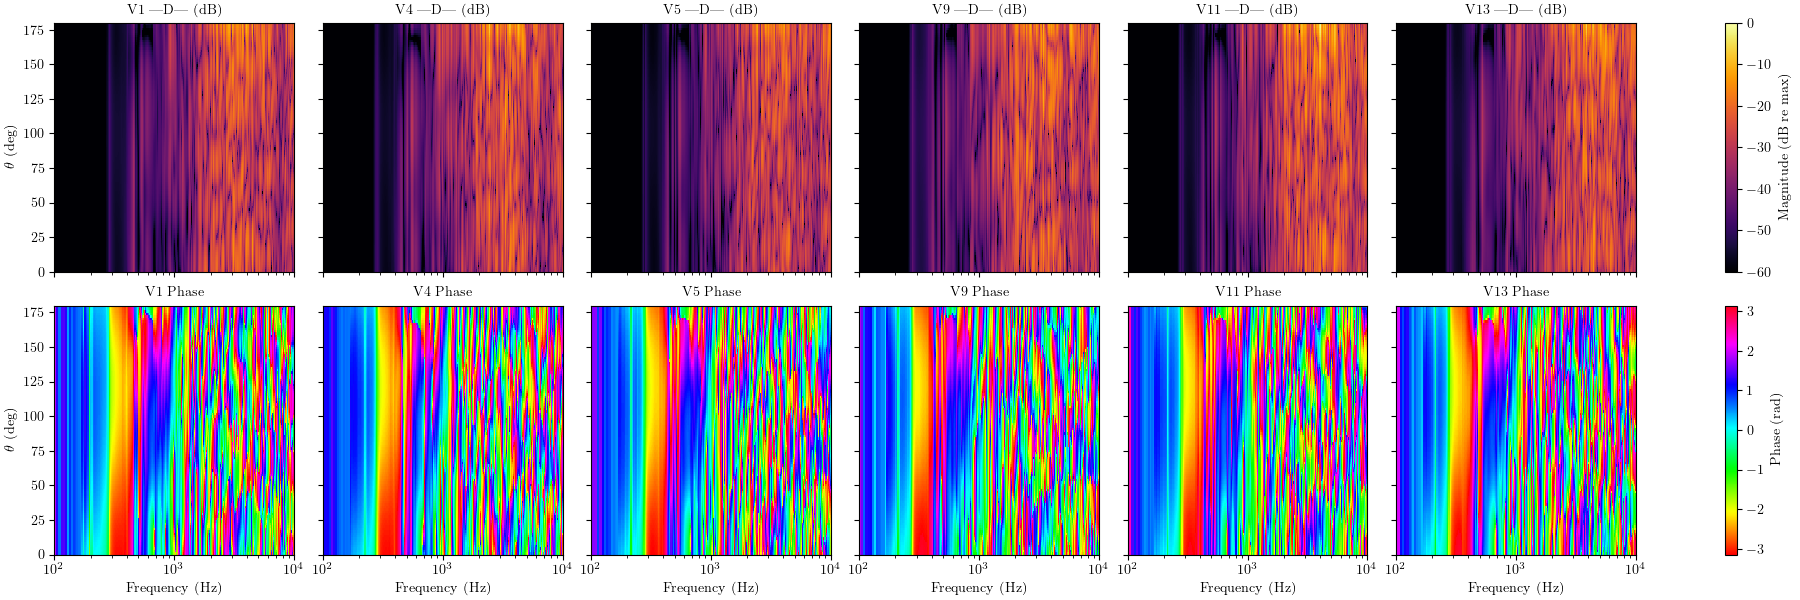

In [12]:
# Build a first row of heatmaps where, for each violin, in the plane phi=0, 
# The magnitude of Diag in dB is plotted with the colormap inferno and a 30dB dynamics, theta versus frequency.
# A second row represents the phase of Diag using the hsv colormap.

# 1. Identify indices for phi ~ 0
phi_values = angles_look[:, 1]
# Find the phi value closest to 0
target_phi = 0
closest_phi = phi_values[np.argmin(np.abs(phi_values - target_phi))]
phi0_mask = np.isclose(phi_values, closest_phi)
phi0_indices = np.where(phi0_mask)[0]

# Sort indices by theta to ensure correct plotting order
sorted_idx_idx = np.argsort(angles_look[phi0_indices, 0])
phi0_indices = phi0_indices[sorted_idx_idx]
thetas_deg = angles_look[phi0_indices, 0] * 180 / np.pi

# 2. Plotting
fig, axes = plt.subplots(2, NbViol, figsize=(NbViol * 3, 6), sharex=True, sharey=True, constrained_layout=True)

# Compute global maximum of the magnitude across all data (Violins, Angles, Frequencies)
GlobalMaxAbs = np.max(np.abs(Diag))

for v in range(NbViol):
    # Slice Diag for the specific violin and phi=0 plane
    # Diag shape: (NbViol, NbDirs, Nbf)
    D_slice = Diag[v, phi0_indices, :]  # Shape: (NbTh_slice, Nbf)
    
    # --- Magnitude Plot (Row 0) ---
    # Normalize to global maximum
    Mag_dB_norm = 20 * np.log10((np.abs(D_slice) / GlobalMaxAbs) + 1e-16) 
    
    ax_mag = axes[0, v]
    # Use pcolormesh. f is frequency, thetas_deg is theta. 
    # Transposing Mag_dB might depend on shape, but usually (Y, X) matches (thetas, f)
    pcm_mag = ax_mag.pcolormesh(f, thetas_deg, Mag_dB_norm, cmap='inferno', vmin=-60, vmax=0, shading='auto')
    
    ax_mag.set_title(f'V{NumViolon[v]} |D| (dB)')
    ax_mag.set_xscale('log')
    ax_mag.set_xlim(100, 10000)
    if v == 0:
        ax_mag.set_ylabel(r'$\theta$ (deg)')

    # --- Phase Plot (Row 1) ---
    Phase = np.angle(D_slice)
    
    ax_ph = axes[1, v]
    pcm_ph = ax_ph.pcolormesh(f, thetas_deg, Phase, cmap='hsv', vmin=-np.pi, vmax=np.pi, shading='auto')
    
    ax_ph.set_title(f'V{NumViolon[v]} Phase')
    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_xscale('log')
    ax_ph.set_xlim(100, 10000)
    if v == 0:
        ax_ph.set_ylabel(r'$\theta$ (deg)')

fig.colorbar(pcm_mag, ax=axes[0, :], location='right', label='Magnitude (dB re max)')
fig.colorbar(pcm_ph, ax=axes[1, :], location='right', label='Phase (rad)')
plt.show()

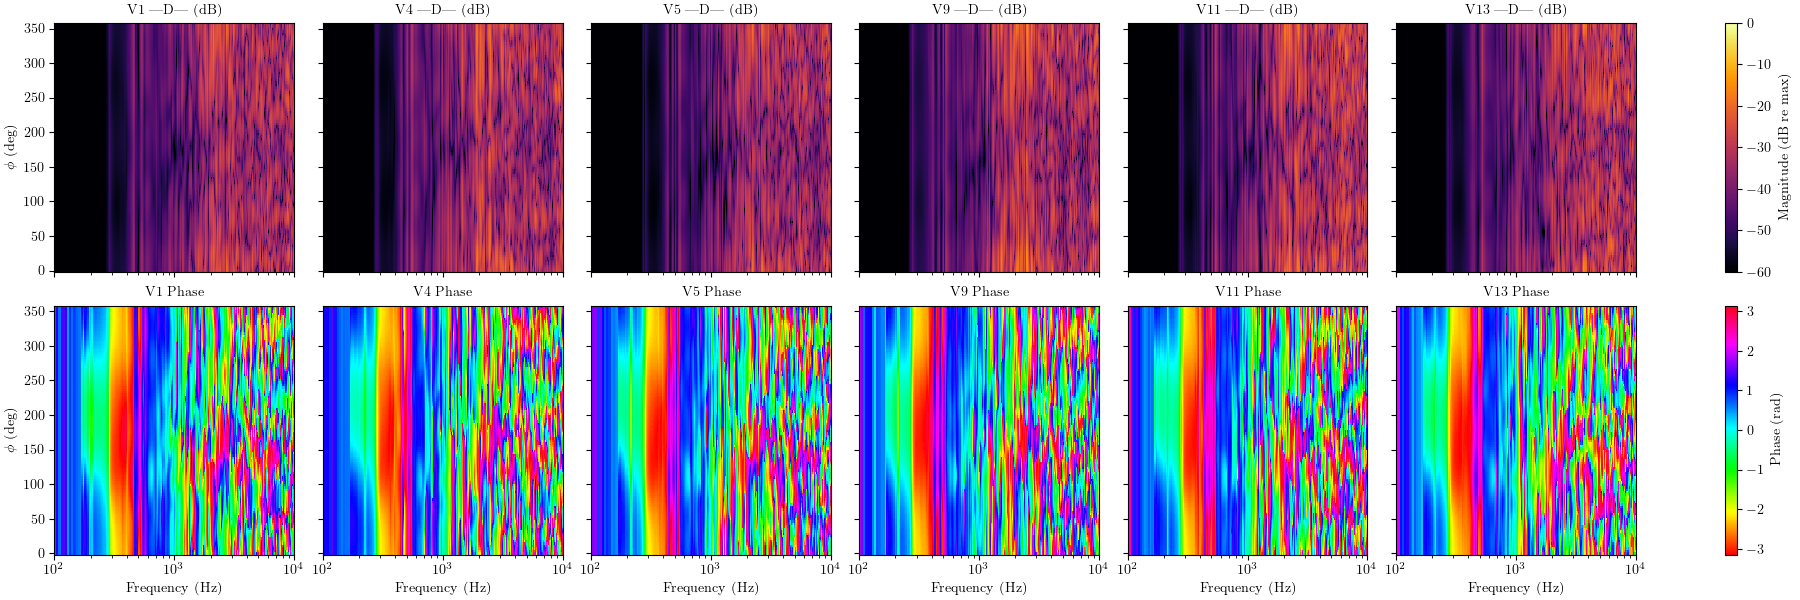

In [13]:
# Equivalent figure for theta = 90 deg (Equatorial plane), phi vs frequency
# Note: Theta=0 corresponds to the North Pole where variation with Phi is zero (singularity).
# We use Theta=pi/2 (90 degrees) to show the equatorial plane.

# 1. Identify indices for theta ~ 90 degrees
theta_values = angles_look[:, 0]
# Find the theta value closest to pi/2
target_theta = np.pi/2
closest_theta = theta_values[np.argmin(np.abs(theta_values - target_theta))]
theta0_mask = np.isclose(theta_values, closest_theta)
theta0_indices = np.where(theta0_mask)[0]

# Sort indices by phi to ensure correct plotting order
sorted_idx_idx = np.argsort(angles_look[theta0_indices, 1])
theta0_indices = theta0_indices[sorted_idx_idx]
phis_deg = angles_look[theta0_indices, 1] * 180 / np.pi

# 2. Plotting
fig, axes = plt.subplots(2, NbViol, figsize=(NbViol * 3, 6), sharex=True, sharey=True, constrained_layout=True)

# Ensure GlobalMaxAbs is defined (if running this cell independently)
if 'GlobalMaxAbs' not in locals():
    GlobalMaxAbs = np.max(np.abs(Diag))

for v in range(NbViol):
    # Slice Diag for the specific violin and theta=90 plane
    D_slice = Diag[v, theta0_indices, :]  # Shape: (NbPh_slice, Nbf)
    
    # --- Magnitude Plot (Row 0) ---
    Mag_dB_norm = 20 * np.log10((np.abs(D_slice) / GlobalMaxAbs) + 1e-16)
    
    ax_mag = axes[0, v]
    pcm_mag = ax_mag.pcolormesh(f, phis_deg, Mag_dB_norm, cmap='inferno', vmin=-60, vmax=0, shading='auto')
    
    ax_mag.set_title(f'V{NumViolon[v]} |D| (dB)')
    ax_mag.set_xscale('log')
    ax_mag.set_xlim(100, 10000)
    if v == 0:
        ax_mag.set_ylabel(r'$\phi$ (deg)')

    # --- Phase Plot (Row 1) ---
    Phase = np.angle(D_slice)
    
    ax_ph = axes[1, v]
    pcm_ph = ax_ph.pcolormesh(f, phis_deg, Phase, cmap='hsv', vmin=-np.pi, vmax=np.pi, shading='auto')
    
    ax_ph.set_title(f'V{NumViolon[v]} Phase')
    ax_ph.set_xlabel('Frequency (Hz)')
    ax_ph.set_xscale('log')
    ax_ph.set_xlim(100, 10000)
    if v == 0:
        ax_ph.set_ylabel(r'$\phi$ (deg)')

fig.colorbar(pcm_mag, ax=axes[0, :], location='right', label='Magnitude (dB re max)')
fig.colorbar(pcm_ph, ax=axes[1, :], location='right', label='Phase (rad)')
plt.show()

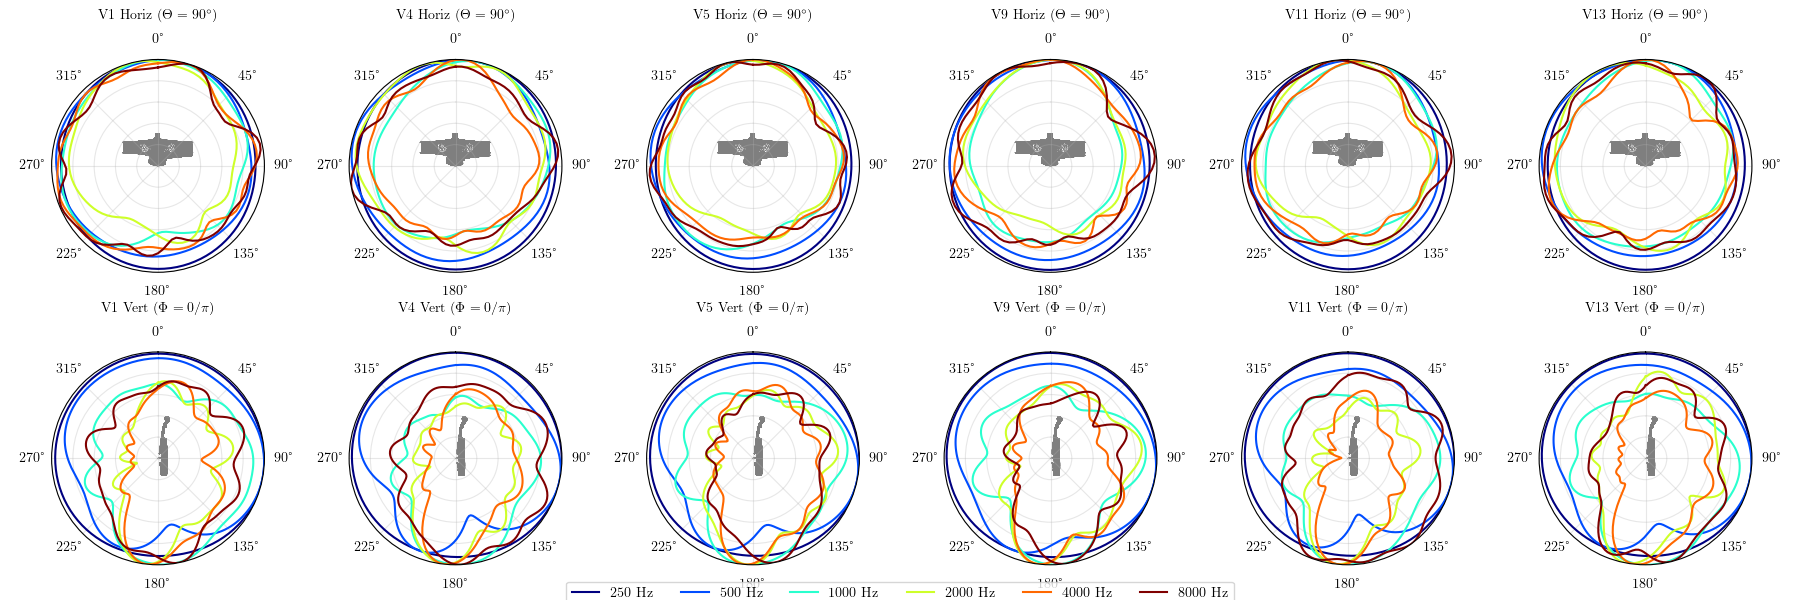

In [17]:
# Polar plots of Diag per Octave Band
# Row 1: Horizontal Plane (Theta = 90 deg)
# Row 2: Vertical Plane (Combined Phi=0 and Phi=pi)

DynRange = 25  # Dynamic range (dB)

# 1. Define Octave Bands
center_freqs = [250, 500, 1000, 2000, 4000, 8000] # Hz
band_indices = []
for fc in center_freqs:
    fmin = fc / np.sqrt(2)
    fmax = fc * np.sqrt(2)
    indices = np.where((f >= fmin) & (f <= fmax))[0]
    if len(indices) > 0:
        band_indices.append((fc, indices))

# 2. Prepare Indices for planes

# Plane Theta = 90 (Horizontal/Equatorial) -> Function of Phi
target_theta = np.pi/2
closest_theta = theta_values[np.argmin(np.abs(theta_values - target_theta))]
indices_th90 = np.where(np.isclose(theta_values, closest_theta))[0]
sort_th90 = np.argsort(angles_look[indices_th90, 1])
indices_th90 = indices_th90[sort_th90]
angles_ph_th90 = angles_look[indices_th90, 1] 

# Plane Phi = 0 (Vertical/Meridional Front)
target_phi = 0
closest_phi = phi_values[np.argmin(np.abs(phi_values - target_phi))]
indices_ph0 = np.where(np.isclose(phi_values, closest_phi))[0]
sort_ph0 = np.argsort(angles_look[indices_ph0, 0])
indices_ph0 = indices_ph0[sort_ph0]
angles_th_ph0 = angles_look[indices_ph0, 0] # 0 to pi

# Plane Phi = pi (Vertical/Meridional Back)
# Find closest phi to pi or -pi
dist_pi = np.minimum(np.abs(phi_values - np.pi), np.abs(phi_values + np.pi))
closest_phi_pi_idx = np.argmin(dist_pi)
# Ensure we get all indices matching this distance (in case multiple match)
# Actually better to just use np.isclose on the min dist
indices_ph180 = np.where(np.isclose(dist_pi, np.min(dist_pi)))[0]
sort_ph180 = np.argsort(angles_look[indices_ph180, 0])
indices_ph180 = indices_ph180[sort_ph180]
angles_th_ph180 = angles_look[indices_ph180, 0] # 0 to pi usually

# 3. Create Figure
fig, axes = plt.subplots(2, NbViol, figsize=(NbViol*3, 6), subplot_kw={'projection': 'polar'})

colors = plt.cm.jet(np.linspace(0, 1, len(band_indices)))

for v in range(NbViol):
    # --- Row 0: Horizontal Plane (Theta=90) ---
    ax_h = axes[0, v]
    ax_h.set_title(f'V{NumViolon[v]} Horiz ($\Theta=90^\circ$)', fontsize=10, pad=10)
    
    for i, (fc, idxs) in enumerate(band_indices):
        D_band = Diag[v, indices_th90, :][:, idxs]
        Mag_band = np.sqrt(np.mean(np.abs(D_band)**2, axis=1))

        # Close the loop for horizontal plot
        Mag_plot = np.append(Mag_band, Mag_band[0])
        Ang_plot = np.append(angles_ph_th90, angles_ph_th90[0] + 2*np.pi) 
        # Note: if angles are -pi..pi, adding 2pi to start usually connects to end appropriately in polar
        
        Mag_dB = 20 * np.log10(Mag_plot / np.max(Mag_band) + 1e-12)
        Mag_dB = np.maximum(Mag_dB, -DynRange) + DynRange
        
        ax_h.plot(Ang_plot, Mag_dB, color=colors[i], linewidth=1.5, label=f'{fc} Hz' if v==0 else "")

    ax_h.set_theta_zero_location("N")
    ax_h.set_theta_direction(-1)
    ax_h.set_ylim(0, DynRange)
    ax_h.set_rticks(np.arange(5, DynRange+1, 5))
    ax_h.set_yticklabels([])
    ax_h.grid(True, alpha=0.3)

    if 'vertices' in locals() and 'faces' in locals():
        r_xy = np.hypot(vertices[:,0], vertices[:,1])
        r_xy = r_xy * 10.0 / (np.max(r_xy) + 1e-12)
        th_xy = np.arctan2(vertices[:,1], vertices[:,0])
        ax_h.triplot(th_xy, r_xy, triangles=faces, color='k', alpha=0.5, linewidth=0.3)

    # --- Row 1: Vertical Plane (Phi=0 and Phi=pi) ---
    ax_v = axes[1, v]
    ax_v.set_title(f'V{NumViolon[v]} Vert ($\Phi=0/\pi$)', fontsize=10, pad=10)
    
    for i, (fc, idxs) in enumerate(band_indices):
        # Front (Phi=0)
        D_0 = Diag[v, indices_ph0, :][:, idxs]
        Mag_0 = np.sqrt(np.mean(np.abs(D_0)**2, axis=1))
        
        # Back (Phi=pi)
        D_180 = Diag[v, indices_ph180, :][:, idxs]
        Mag_180 = np.sqrt(np.mean(np.abs(D_180)**2, axis=1))
        
        # Combine: 0->pi (Front) then 2pi-pi -> 2pi-0 (Back, reversed)
        Mag_full = np.concatenate([Mag_0, Mag_180[::-1]])
        Ang_full = np.concatenate([angles_th_ph0, 2*np.pi - angles_th_ph180[::-1]])
        
        # Close loop (Back to North Pole)
        Mag_full = np.append(Mag_full, Mag_full[0])
        Ang_full = np.append(Ang_full, 2*np.pi)

        # Normalize to max of the WHOLE plane
        Mag_dB = 20 * np.log10(Mag_full / np.max(Mag_full) + 1e-12)
        Mag_dB = np.maximum(Mag_dB, -DynRange) + DynRange
        
        ax_v.plot(Ang_full, Mag_dB, color=colors[i], linewidth=1.5, label=f'{fc} Hz' if v==0 else "")

    ax_v.set_theta_zero_location("N")
    ax_v.set_theta_direction(-1)
    # Full circle default
    ax_v.set_ylim(0, DynRange)
    ax_v.set_rticks(np.arange(5, DynRange+1, 5))
    ax_v.set_yticklabels([])
    ax_v.grid(True, alpha=0.3)

    if 'vertices' in locals() and 'faces' in locals():
        r_xz = np.hypot(vertices[:,0], vertices[:,2])
        r_xz = r_xz * 10.0 / (np.max(r_xz) + 1e-12)
        th_xz = np.arctan2(vertices[:,0], vertices[:,2])
        # Force angle range [0, 2pi] to match plot
        th_xz = np.where(th_xz < 0, th_xz + 2*np.pi, th_xz)
        ax_v.triplot(th_xz, r_xz, triangles=faces, color='k', alpha=0.5, linewidth=0.3)

# Global Legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(band_indices), bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.show()